**Session 10 :  Object Localization - YOLO**

***Assignemnt Objective: Train ResNet18 on Tiny Imagenet dataset** 
1. Tranin/Validayion split: 70/30 split
2. Epochs: 50 Epochs. 
3. Target: 50%+ Validation Accuracy.


In [0]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

In [0]:
import sys
sys.path.append("/content/drive/My Drive/tsai/tsai_repo")

**IMPORTS**

In [0]:
import torch
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np

In [0]:
from data_loader.data_loader_tinyimagenet import dataLoader
from data_transformations.transform import AlbumentationTransforms
from models.resnet_tiny_imagenet import ResNet18
# from models.resnet18 import ResNet18

from utils import denormalize
from training.training import train
from scoring.scoring import test
from scoring.accuracy import showMeasurePlots
from scoring.missclassified_images import identifyImages

**TRANSFORMATIONS**

1. Rotate
2. Horizontal Flip
3. RGB shift
4. Cutout

In [0]:
#Transforms
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                                      #  A.Rotate((-30.0, 30.0)),
                                      #  A.HorizontalFlip(),
                                      #  A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs) #,
                                      #  A.Cutout(num_holes=4) # fillvalue is 0 after normalizing as mean is 0
                                       ])

fillmeans = (np.array(channel_means)).astype(np.uint8)

# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

**DATA LOADER**

1. Train dataset has 1,00,000 images (500 images from every class)
2. Classes = 200 

In [6]:
#Dataload
# dataloader = dataLoader(path = 'C:/Users/pbhat/Google Drive/tsai_repo/datasets/tiny-imagenet-200/tiny-imagenet-200/')
dataloader = dataLoader(path = '/content/drive/My Drive/tsai_repo/datasets/tiny-imagenet-200/tiny-imagenet-200/')

train_loader, val_loader , classes= dataloader.get_train_loader(train_transforms,split=True)
# test_loader = dataloader.get_train_loader(test_transforms)
# classes = dataloader.get_classes()
print(len(train_loader.dataset))
print(len(val_loader.dataset))

print(classes)



CUDA is available: True
Initiated Data Loader with: {'shuffle': True, 'batch_size': 128, 'num_workers': 4, 'pin_memory': True}
Loading Tinyimagenet
traindata is split
70000
30000
['goldfish', 'European fire salamander', 'bullfrog', 'tailed frog', 'American alligator', 'boa constrictor', 'trilobite\n', 'scorpion\n', 'black widow', 'tarantula\n', 'centipede\n', 'goose\n', 'koala', 'jellyfish\n', 'brain coral\n', 'snail\n', 'slug\n', 'sea slug', 'American lobster', 'spiny lobster', 'black stork', 'king penguin', 'albatross', 'dugong', 'Chihuahua\n', 'Yorkshire terrier\n', 'golden retriever\n', 'Labrador retriever\n', 'German shepherd', 'standard poodle\n', 'tabby', 'Persian cat\n', 'Egyptian cat\n', 'cougar', 'lion', 'brown bear', 'ladybug', 'fly\n', 'bee\n', 'grasshopper', 'walking stick', 'cockroach', 'mantis', 'dragonfly', 'monarch', 'sulphur butterfly', 'sea cucumber', 'guinea pig', 'hog', 'ox\n', 'bison\n', 'bighorn', 'gazelle\n', 'Arabian camel', 'orangutan', 'chimpanzee', 'baboon\n

torch.Size([3, 64, 64])
tensor([150, 171,   4, 103,  31,  86,  47, 161,  47,  35,  89, 109, 180, 188,
        129,  15,  64, 167,   1,   3, 100,  11,  69, 169, 153, 155, 148, 136,
         84, 136, 177,  39,  79,  89, 144, 141, 175,   4,  12, 168, 136,  95,
        157,  26,  74, 170, 187, 141,  36,  23,  94, 129,  97,  59, 103,   4,
        146,  61,  60,  94, 184, 197, 159, 119,  80, 140,  79,  94, 186,  30,
        164, 187, 109,  89,  48, 172, 153,  54,  79,  98, 168,  41, 197, 112,
         17,  75,  85, 185, 116,  46,   6, 183, 134, 151, 153,  53, 137, 170,
        194, 188,  91,  28, 168,  88,   0,   5,  73,  86,  19,  78,  12, 128,
        173,  59, 105, 183,  42,   4, 116, 156,  13, 177,   0, 189,  94,  72,
         20,  80])


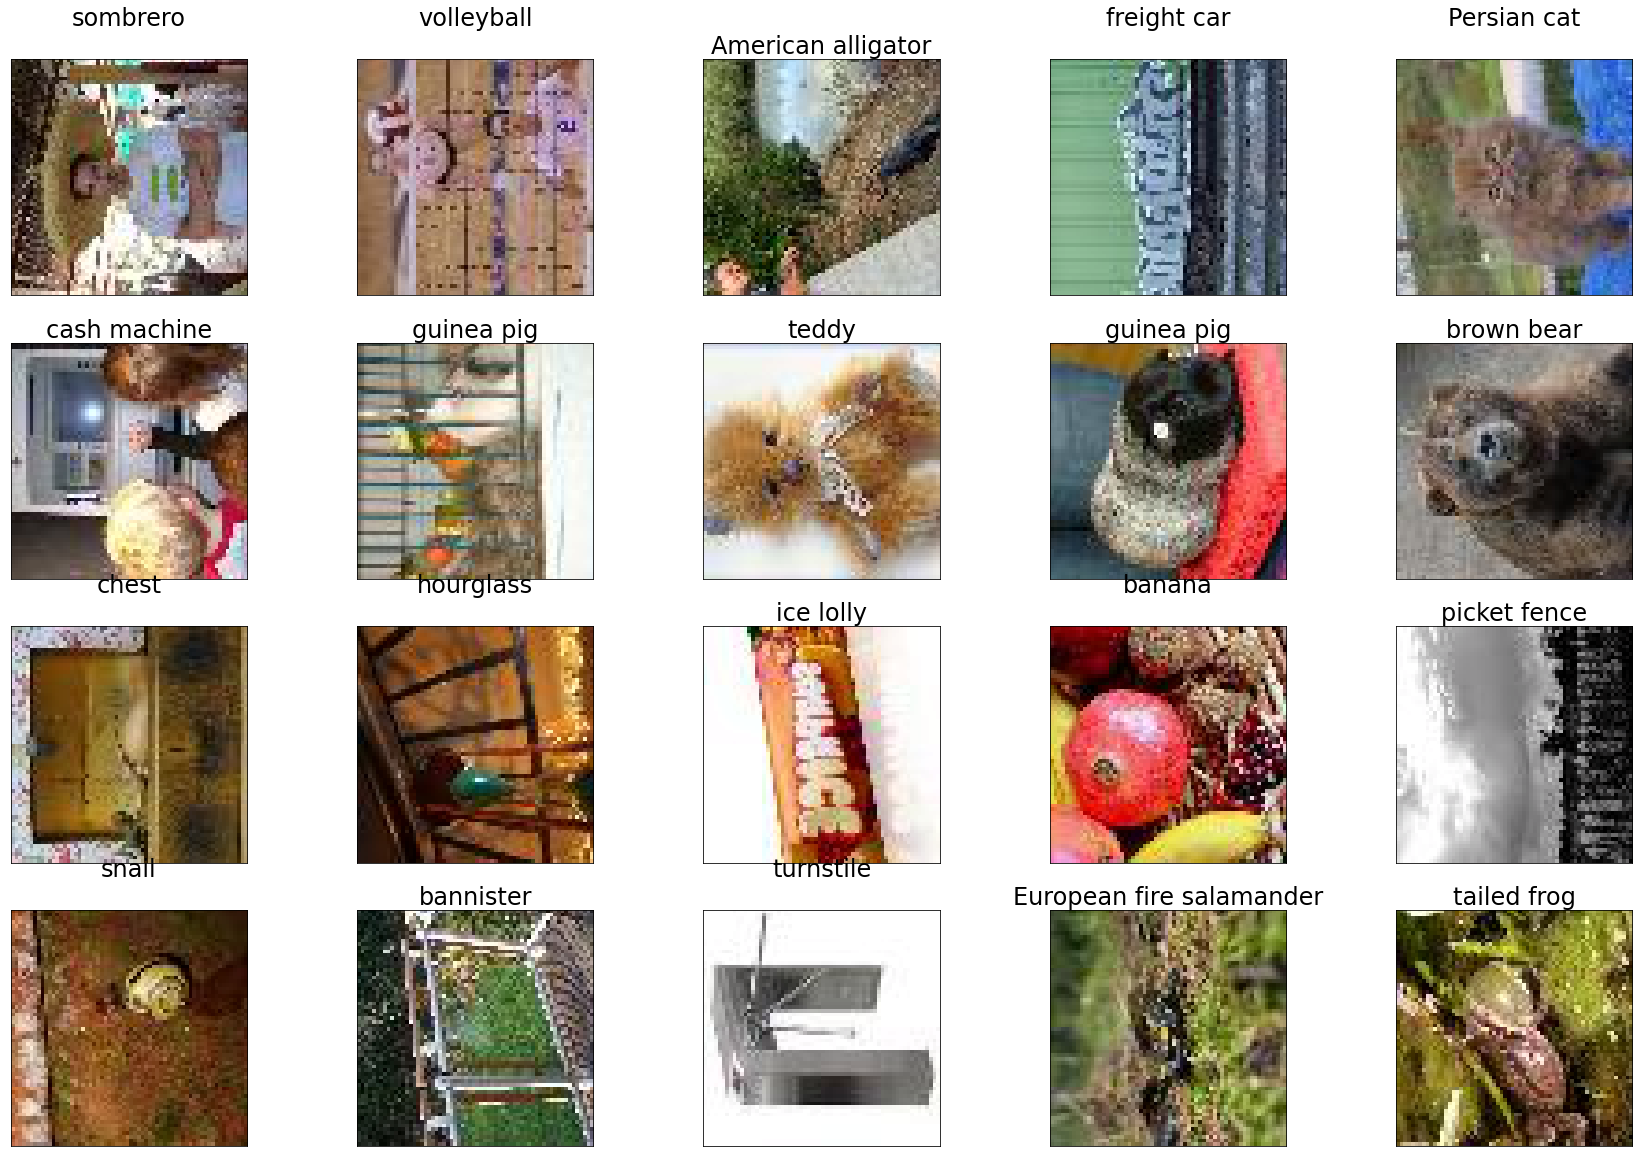

In [7]:
#Plot few images
dataiter = iter(train_loader)
images, target = next(dataiter)
print(images[0].shape)
print(target)

#If the picture in sormalised then denormalise and plot it
fig = plt.figure(figsize=(30,20))
for i in range(0,20):
    plt_image = denormalize(images[i],channel_means,channel_stdevs)
    plt_image = np.transpose(plt_image,[2,1,0])
    plt_image = np.uint8(255*plt_image)
    plt.subplot(4,5,i+1)
    plt.imshow(plt_image)
    plt.title(str(classes[target[i]]),fontsize=24)
    plt.xticks([])
    plt.yticks([])
fig.show()

**MODEL LOADER**

In this section we are loading the resnet18 model


In [8]:
#Load the model
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# model = Net().to(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

**EXECUTE**

1. Set folowing paremters
  1. Number of epochs
  2. l1 and l2 regularization parameters
2. Plot the accuracy Curves
3. Plot the Miss classified images
4. Run gradcam on misclassified images

In [9]:
epochs = 50
L2lambda = 0
L1lambda = 0
test_losses = []
train_losses = []
test_accuracy = []
train_accuracy = []
best_lr = 0.05

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=L2lambda)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min', 
                                           factor=0.1, # learning rate will be reduced by this factor 
                                           patience=10, # wait foe epochs to reduce
                                           verbose=True, #print the update 
                                           threshold=0.0001, 
                                           threshold_mode='rel', 
                                           cooldown=0, #wait till we can resumen the normal operation
                                           min_lr=0, 
                                           eps=1e-08)
for epoch in range(0, epochs):
    print("EPOCH:",epoch)
    train(model, device, train_loader, optimizer, train_losses, train_accuracy, L1lambda=0,scheduler=None)
    
    test(model, device, val_loader,test_losses,test_accuracy)
torch.save(model,"model_s12")

  0%|          | 0/547 [00:00<?, ?it/s]

EPOCH: 0
cuda


loss=5.2240495681762695 batch_id=19:   4%|▎         | 20/547 [08:38<2:05:18, 14.27s/it]

KeyboardInterrupt: ignored

In [0]:
showMeasurePlots.plot_accuracy_curves(train_accuracy,test_accuracy,epochs)
showMeasurePlots.plot_loss_curves(train_losses,test_losses,epochs)

In [0]:
misclass_data_r, misclass_targets_r,misclass_pred_r = identifyImages.misclassified(model,test_loader,device)
from matplotlib.pyplot import figure
from utils import denormalize
fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
misclass_targets_r_cpu = misclass_targets_r.cpu().numpy()
misclass_pred_r_cpu = misclass_pred_r.cpu().numpy()
for num in range(0,20):
    plt.subplot(5,5,num+1)
    plt.tight_layout()
    mis_class_img = misclass_data_r[num]
    mis_class_img_cpu = mis_class_img.cpu()
    plt_image = denormalize(mis_class_img_cpu,channel_means,channel_stdevs)
    plt_image = np.transpose(plt_image, (1, 2, 0))
    plt_image = np.uint8(255*plt_image)
    plt.imshow(plt_image)
    plt.xticks([])
    plt.yticks([])
    plt.title("Predicted: {} \n Actual:{}".format(
    classes[misclass_pred_r_cpu[num]], classes[misclass_targets_r_cpu[num]]))


In [0]:
correctclass_data_r, correctclass_targets_r,correctclass_pred_r = identifyImages.correct_classified(model,test_loader,device)
from matplotlib.pyplot import figure
fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
correctclass_targets_r_cpu = correctclass_targets_r.cpu().numpy()
correctclass_pred_r_cpu = correctclass_pred_r.cpu().numpy()
for num in range(0,20):
    plt.subplot(5,5,num+1)
    plt.tight_layout()
    correct_class_img = correctclass_data_r[num]
    correct_class_img_cpu = correct_class_img.cpu()
    plt_image = denormalize(correct_class_img_cpu,channel_means,channel_stdevs)
    plt_image = np.transpose(plt_image, (1, 2, 0))
    plt_image = np.uint8(255*plt_image)
    plt.imshow(plt_image)
    plt.xticks([])
    plt.yticks([])
    plt.title("Predicted: {} \n Actual:{}".format(
    classes[correctclass_pred_r_cpu[num]], classes[correctclass_targets_r_cpu[num]]))


**GRADCAM**

Gradcam on 10 missclassified images

In [0]:
target_layers = ["layer1", "layer2","layer3", "layer4"]
images = misclass_data_r[0:10]
target_classes = misclass_targets_r[0:10]
gradcam_output, probs, predicted_classes = gradcam(images, target_classes, model, target_layers)
plot_gradcam_1(gradcam_output, images, target_classes, target_layers, classes, predicted_classes,channel_means,channel_stdevs)


Gradcam on 10 correctly classifed images

In [0]:
target_layers = ["layer1", "layer2","layer3", "layer4"]
images = correctclass_data_r[0:10]
target_classes = correctclass_targets_r[0:10]
gradcam_output, probs, predicted_classes = gradcam(images, target_classes, model, target_layers)
plot_gradcam_1(gradcam_output, images, target_classes, target_layers, classes, predicted_classes,channel_means,channel_stdevs)
